# Relief Pitcher Rest Day Analysis: Key Insights

This notebook summarizes the most relevant findings on how rest days affect MLB relief pitcher performance (velocity, control, outcomes).

In [43]:
# Imports and data loading
(pd := __import__('pandas'))
(np := __import__('numpy'))
(pl := __import__('polars'))
(ggplot, aes, geom_col, geom_boxplot, geom_point, geom_text, labs, theme_minimal, theme) = (
    __import__('plotnine').ggplot,
    __import__('plotnine').aes,
    __import__('plotnine').geom_col,
    __import__('plotnine').geom_boxplot,
    __import__('plotnine').geom_point,
    __import__('plotnine').geom_text,
    __import__('plotnine').labs,
    __import__('plotnine').theme_minimal,
    __import__('plotnine').theme
)
(__import__('warnings').filterwarnings('ignore'))

In [44]:
# Load processed reliever data
(relievers := pl.read_parquet('data/statcast_relievers_final.parquet')).head(3)

pitcher_id,date,game_id,velocity,spin_rate,pitch_type_abbr,pitch_type,pitch_result,ab_result,pitch_call,strike_zone,ball_count,strike_count,outs,inning,top_bottom,home_team,away_team,ab_number,pitch_num,batted_ball_type,runner_1b,runner_2b,runner_3b,away_score,home_score,defense_score,offense_score,game_type,batter_side,pitcher_hand,pitcher_days_since_prev_game,pitcher_days_until_next_game,horizontal_movement,vertical_movement,plate_x_position,plate_z_position,year,pitcher_name
i64,datetime[ns],i64,f64,i64,str,str,str,str,str,i64,i64,i64,i64,i64,str,str,str,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64,f64,f64,f64,f64,i32,str
433589,2021-04-01 00:00:00,634640,85.8,1989,"""FF""","""4-Seam Fastball""","""ball""",null,"""B""",11,0,0,2,6,"""Top""","""ATH""","""HOU""",41,1,null,null,670541,null,3,0,0,3,"""R""","""R""","""R""",null,3,-0.58,1.36,-0.88,3.62,2021,"""Yusmeiro Petit"""
433589,2021-04-01 00:00:00,634640,87.5,2182,"""FF""","""4-Seam Fastball""","""ball""",null,"""B""",12,0,0,1,6,"""Top""","""ATH""","""HOU""",39,1,null,663656,608324,null,1,0,0,1,"""R""","""R""","""R""",null,3,-0.5,1.58,1.87,3.41,2021,"""Yusmeiro Petit"""
433589,2021-04-01 00:00:00,634640,85.6,2136,"""FF""","""4-Seam Fastball""","""ball""",null,"""B""",11,0,0,2,6,"""Top""","""ATH""","""HOU""",40,1,null,663656,608324,null,1,0,0,1,"""R""","""L""","""R""",null,3,-0.49,1.4,-1.89,3.07,2021,"""Yusmeiro Petit"""


# Rest Day Investigation

In [45]:
# Calculate rest days between appearances
(pitch_count_rest_days := (
    relievers
    .group_by(['pitcher_id', 'pitcher_name', 'date', 'game_id'])
    .agg(pl.col('pitch_num').count().alias('pitch_count'))
    .sort(['pitcher_id', 'date'])
    .with_columns([
        pl.col('date').diff().over('pitcher_id').dt.total_days().alias('rest_days')
    ])
    .select(['pitcher_name', 'game_id', 'date', 'pitcher_id', 'rest_days', 'pitch_count'])
).drop_nulls())

pitcher_name,game_id,date,pitcher_id,rest_days,pitch_count
str,i64,datetime[ns],i64,i64,u32
"""Yusmeiro Petit""",634651,2021-04-04 00:00:00,433589,3,26
"""Yusmeiro Petit""",634628,2021-04-06 00:00:00,433589,2,16
"""Yusmeiro Petit""",634567,2021-04-07 00:00:00,433589,1,10
"""Yusmeiro Petit""",634537,2021-04-09 00:00:00,433589,2,8
"""Yusmeiro Petit""",632231,2021-04-12 00:00:00,433589,3,10
…,…,…,…,…,…
"""Spencer Bivens""",746985,2024-09-19 00:00:00,702352,4,37
"""Spencer Bivens""",746255,2024-09-21 00:00:00,702352,2,28
"""Spencer Bivens""",747150,2024-09-23 00:00:00,702352,2,21


In [46]:
relievers.select(pl.col('pitch_type')).unique().to_series().to_list()

['4-Seam Fastball',
 'Sinker',
 'Pitch Out',
 'Curveball',
 'Changeup',
 'Sweeper',
 'Knuckle Curve',
 'Slurve',
 'Screwball',
 'Slider',
 'Other',
 'Split-Finger',
 'Cutter',
 'Slow Curve',
 None]

In [47]:
# Create outing-level aggregations (fastballs only for velocity/spin)
(outing_table := (relievers
    .filter(pl.col('pitch_type').is_in(['4-Seam Fastball', 'Sinker', 'Cutter', '2-Seam Fastball']))
    .group_by(['pitcher_id', 'game_id', 'date', 'year', 'pitcher_name'])
    .agg([
        pl.len().alias('fb_count'),
        pl.col('velocity').mean().alias('mean_fb_velocity'),
        pl.col('velocity').max().alias('max_fb_velocity'),
        pl.col('spin_rate').mean().alias('mean_fb_spin_rate'),
        pl.col('horizontal_movement').mean().alias('mean_h_movement'),
        pl.col('vertical_movement').mean().alias('mean_v_movement'),
        pl.col('inning').first().alias('inning_entered'),
        pl.col('pitcher_hand').first().alias('pitcher_hand'),
        (pl.col('defense_score').first() - pl.col('offense_score').first()).alias('score_diff'),
    ])
    .sort(['pitcher_id', 'date'])
))

pitcher_id,game_id,date,year,pitcher_name,fb_count,mean_fb_velocity,max_fb_velocity,mean_fb_spin_rate,mean_h_movement,mean_v_movement,inning_entered,pitcher_hand,score_diff
i64,i64,datetime[ns],i32,str,u32,f64,f64,f64,f64,f64,i64,str,i64
433589,634640,2021-04-01 00:00:00,2021,"""Yusmeiro Petit""",8,86.3125,87.8,2096.75,-0.3475,1.41,6,"""R""",-3
433589,634651,2021-04-04 00:00:00,2021,"""Yusmeiro Petit""",21,85.214286,88.1,2094.333333,-0.298571,1.426667,7,"""R""",-7
433589,634628,2021-04-06 00:00:00,2021,"""Yusmeiro Petit""",12,85.091667,87.3,2077.833333,-0.3275,1.535833,8,"""R""",-3
433589,634567,2021-04-07 00:00:00,2021,"""Yusmeiro Petit""",8,84.775,87.4,2039.0,-0.325,1.4825,10,"""R""",0
433589,634537,2021-04-09 00:00:00,2021,"""Yusmeiro Petit""",8,86.1375,89.2,2141.5,-0.31375,1.555,7,"""R""",0
…,…,…,…,…,…,…,…,…,…,…,…,…,…
702352,746985,2024-09-19 00:00:00,2024,"""Spencer Bivens""",32,94.1,97.5,2093.96875,-0.650938,0.590938,8,"""R""",-1
702352,746255,2024-09-21 00:00:00,2024,"""Spencer Bivens""",18,95.127778,97.2,2105.0,-0.842222,0.501667,7,"""R""",9
702352,747150,2024-09-23 00:00:00,2024,"""Spencer Bivens""",14,94.907143,97.1,2092.5,-0.977857,0.445714,6,"""R""",3


In [48]:
# 3. Join rest days and add previous outing pitch count
(outing_table := (outing_table
    .join(
        pitch_count_rest_days.select(['pitcher_id', 'game_id', 'rest_days', 'pitch_count']),
        on=['pitcher_id', 'game_id'],
        how='left'
    )
    .with_columns([
        pl.col('pitch_count').shift(1).over('pitcher_id').alias('prev_pitch_count'),
    ])
).drop_nulls()).head(3)

pitcher_id,game_id,date,year,pitcher_name,fb_count,mean_fb_velocity,max_fb_velocity,mean_fb_spin_rate,mean_h_movement,mean_v_movement,inning_entered,pitcher_hand,score_diff,rest_days,pitch_count,prev_pitch_count
i64,i64,datetime[ns],i32,str,u32,f64,f64,f64,f64,f64,i64,str,i64,i64,u32,u32
433589,634628,2021-04-06 00:00:00,2021,"""Yusmeiro Petit""",12,85.091667,87.3,2077.833333,-0.3275,1.535833,8,"""R""",-3,2,16,26
433589,634567,2021-04-07 00:00:00,2021,"""Yusmeiro Petit""",8,84.775,87.4,2039.0,-0.325,1.4825,10,"""R""",0,1,10,16
433589,634537,2021-04-09 00:00:00,2021,"""Yusmeiro Petit""",8,86.1375,89.2,2141.5,-0.31375,1.555,7,"""R""",0,2,8,10


In [49]:
# 4. Add season baselines and deviations
(outing_table := (outing_table
    .join(
        outing_table
        .group_by(['pitcher_id', 'year'])
        .agg([
            pl.col('mean_fb_velocity').mean().alias('season_avg_fb_velo'),
            pl.col('mean_fb_spin_rate').mean().alias('season_avg_fb_spin'),
        ]),
        on=['pitcher_id', 'year'],
        how='left'
    )
    .with_columns([
        (pl.col('mean_fb_velocity') - pl.col('season_avg_fb_velo')).alias('velo_deviation'),
        (pl.col('mean_fb_spin_rate') - pl.col('season_avg_fb_spin')).alias('spin_deviation'),
    ])
))

pitcher_id,game_id,date,year,pitcher_name,fb_count,mean_fb_velocity,max_fb_velocity,mean_fb_spin_rate,mean_h_movement,mean_v_movement,inning_entered,pitcher_hand,score_diff,rest_days,pitch_count,prev_pitch_count,season_avg_fb_velo,season_avg_fb_spin,velo_deviation,spin_deviation
i64,i64,datetime[ns],i32,str,u32,f64,f64,f64,f64,f64,i64,str,i64,i64,u32,u32,f64,f64,f64,f64
433589,634628,2021-04-06 00:00:00,2021,"""Yusmeiro Petit""",12,85.091667,87.3,2077.833333,-0.3275,1.535833,8,"""R""",-3,2,16,26,86.615973,2137.198876,-1.524306,-59.365543
433589,634567,2021-04-07 00:00:00,2021,"""Yusmeiro Petit""",8,84.775,87.4,2039.0,-0.325,1.4825,10,"""R""",0,1,10,16,86.615973,2137.198876,-1.840973,-98.198876
433589,634537,2021-04-09 00:00:00,2021,"""Yusmeiro Petit""",8,86.1375,89.2,2141.5,-0.31375,1.555,7,"""R""",0,2,8,10,86.615973,2137.198876,-0.478473,4.301124
433589,632231,2021-04-12 00:00:00,2021,"""Yusmeiro Petit""",7,86.357143,87.7,2242.0,-0.18,1.548571,6,"""R""",3,3,10,8,86.615973,2137.198876,-0.25883,104.801124
433589,632206,2021-04-13 00:00:00,2021,"""Yusmeiro Petit""",4,86.7,88.3,2058.5,-0.0875,1.3625,7,"""R""",0,1,6,10,86.615973,2137.198876,0.084027,-78.698876
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
702352,746985,2024-09-19 00:00:00,2024,"""Spencer Bivens""",32,94.1,97.5,2093.96875,-0.650938,0.590938,8,"""R""",-1,4,37,13,94.048879,1941.835625,0.051121,152.133125
702352,746255,2024-09-21 00:00:00,2024,"""Spencer Bivens""",18,95.127778,97.2,2105.0,-0.842222,0.501667,7,"""R""",9,2,28,37,94.048879,1941.835625,1.078899,163.164375
702352,747150,2024-09-23 00:00:00,2024,"""Spencer Bivens""",14,94.907143,97.1,2092.5,-0.977857,0.445714,6,"""R""",3,2,21,28,94.048879,1941.835625,0.858264,150.664375


In [50]:
# 5. Sanity check
print("Shape:", outing_table.shape)
print("\nNull counts:")
print(outing_table.null_count())
print("\nRest days distribution:")
print(outing_table['rest_days'].value_counts().sort('rest_days'))
print("\nVelo deviation summary:")
print(outing_table['velo_deviation'].describe())

Shape: (36615, 21)

Null counts:
shape: (1, 21)
┌────────────┬─────────┬──────┬──────┬───┬──────────────┬──────────────┬─────────────┬─────────────┐
│ pitcher_id ┆ game_id ┆ date ┆ year ┆ … ┆ season_avg_f ┆ season_avg_f ┆ velo_deviat ┆ spin_deviat │
│ ---        ┆ ---     ┆ ---  ┆ ---  ┆   ┆ b_velo       ┆ b_spin       ┆ ion         ┆ ion         │
│ u32        ┆ u32     ┆ u32  ┆ u32  ┆   ┆ ---          ┆ ---          ┆ ---         ┆ ---         │
│            ┆         ┆      ┆      ┆   ┆ u32          ┆ u32          ┆ u32         ┆ u32         │
╞════════════╪═════════╪══════╪══════╪═══╪══════════════╪══════════════╪═════════════╪═════════════╡
│ 0          ┆ 0       ┆ 0    ┆ 0    ┆ … ┆ 0            ┆ 0            ┆ 0           ┆ 0           │
└────────────┴─────────┴──────┴──────┴───┴──────────────┴──────────────┴─────────────┴─────────────┘

Rest days distribution:
shape: (157, 2)
┌───────────┬───────┐
│ rest_days ┆ count │
│ ---       ┆ ---   │
│ i64       ┆ u32   │
╞═══════════╪══

In [51]:
# 6. Filter to meaningful rest day range
(outing_table := outing_table
    .filter(pl.col('rest_days') <= 10)
)

print("Shape after filter:", outing_table.shape)
print("\nRest days distribution:")
print(outing_table['rest_days'].value_counts().sort('rest_days'))

Shape after filter: (35737, 21)

Rest days distribution:
shape: (11, 2)
┌───────────┬───────┐
│ rest_days ┆ count │
│ ---       ┆ ---   │
│ i64       ┆ u32   │
╞═══════════╪═══════╡
│ 0         ┆ 31    │
│ 1         ┆ 6837  │
│ 2         ┆ 10768 │
│ 3         ┆ 8499  │
│ 4         ┆ 4769  │
│ …         ┆ …     │
│ 6         ┆ 1211  │
│ 7         ┆ 639   │
│ 8         ┆ 329   │
│ 9         ┆ 148   │
│ 10        ┆ 67    │
└───────────┴───────┘


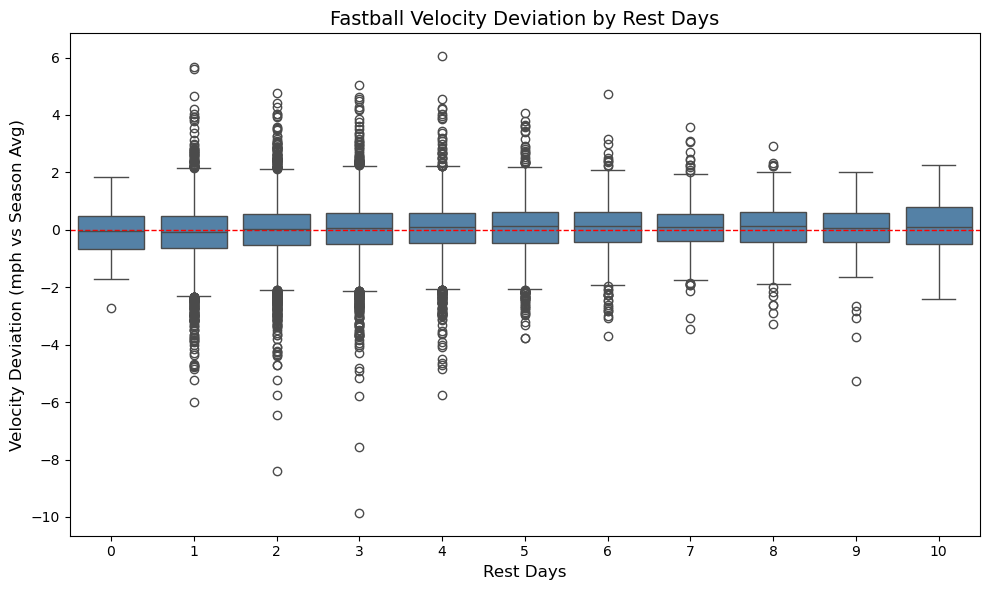

In [52]:
# 7. Velocity deviation by rest days
import seaborn as sns
import matplotlib.pyplot as plt

df = outing_table.to_pandas()

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x='rest_days', y='velo_deviation', color='steelblue', ax=ax)
ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax.set_title('Fastball Velocity Deviation by Rest Days', fontsize=14)
ax.set_xlabel('Rest Days', fontsize=12)
ax.set_ylabel('Velocity Deviation (mph vs Season Avg)', fontsize=12)
plt.tight_layout()
plt.show()

In [53]:
df_means = (outing_table
    .group_by('rest_days')
    .agg([
        pl.col('velo_deviation').mean().alias('mean_velo_dev'),
        pl.col('velo_deviation').std().alias('std_velo_dev'),
        pl.len().alias('count'),
    ])
    .sort('rest_days')
    .to_pandas()
)

# Calculate standard error
df_means['se'] = df_means['std_velo_dev'] / (df_means['count'] ** 0.5)
df_means


,rest_days,mean_velo_dev,std_velo_dev,count,se
0,0,-0.132494,0.906987,31,0.162900
1,1,-0.100226,0.925208,6837,0.011189
2,2,-0.012719,0.883072,10768,0.008510
3,3,0.038375,0.901915,8499,0.009783
4,4,0.046503,0.896601,4769,0.012983
5,5,0.081458,0.886763,2439,0.017956
6,6,0.089353,0.862464,1211,0.024784
7,7,0.086736,0.830674,639,0.032861
8,8,0.080666,0.888905,329,0.049007
9,9,0.010244,1.024708,148,0.084230


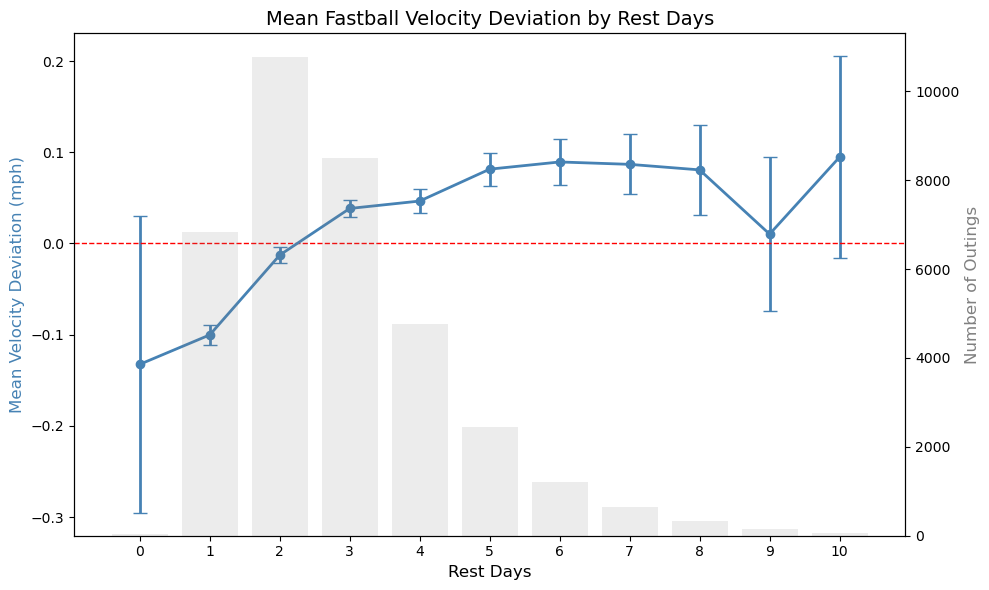

In [54]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Line plot with error bars (left axis)
ax1.errorbar(df_means['rest_days'], df_means['mean_velo_dev'], yerr=df_means['se'], 
             marker='o', color='steelblue', linewidth=2, capsize=5)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax1.set_xlabel('Rest Days', fontsize=12)
ax1.set_ylabel('Mean Velocity Deviation (mph)', fontsize=12, color='steelblue')

# Bar chart for sample size (right axis)
ax2 = ax1.twinx()
ax2.bar(df_means['rest_days'], df_means['count'], alpha=0.15, color='gray')
ax2.set_ylabel('Number of Outings', fontsize=12, color='gray')

ax1.set_title('Mean Fastball Velocity Deviation by Rest Days', fontsize=14)
ax1.set_xticks(range(0, 11))
plt.tight_layout()
plt.show()

In [55]:
# 10. Calculate mean spin rate deviation by rest days
df_spin_means = (outing_table
    .group_by('rest_days')
    .agg([
        pl.col('spin_deviation').mean().alias('mean_spin_dev'),
        pl.col('spin_deviation').std().alias('std_spin_dev'),
        pl.len().alias('count'),
    ])
    .sort('rest_days')
    .to_pandas()
)

df_spin_means['se'] = df_spin_means['std_spin_dev'] / (df_spin_means['count'] ** 0.5)

df_spin_means

,rest_days,mean_spin_dev,std_spin_dev,count,se
0,0,-3.361668,62.283418,31,11.186432
1,1,-2.258446,75.507350,6837,0.913180
2,2,0.094830,73.889459,10768,0.712057
3,3,0.712219,74.081400,8499,0.803573
4,4,2.204260,70.824248,4769,1.025577
5,5,1.150137,74.346353,2439,1.505406
6,6,1.545060,69.485419,1211,1.996740
7,7,-6.364872,74.628811,639,2.952270
8,8,-5.550504,68.720000,329,3.788656
9,9,3.517182,69.259676,148,5.693110


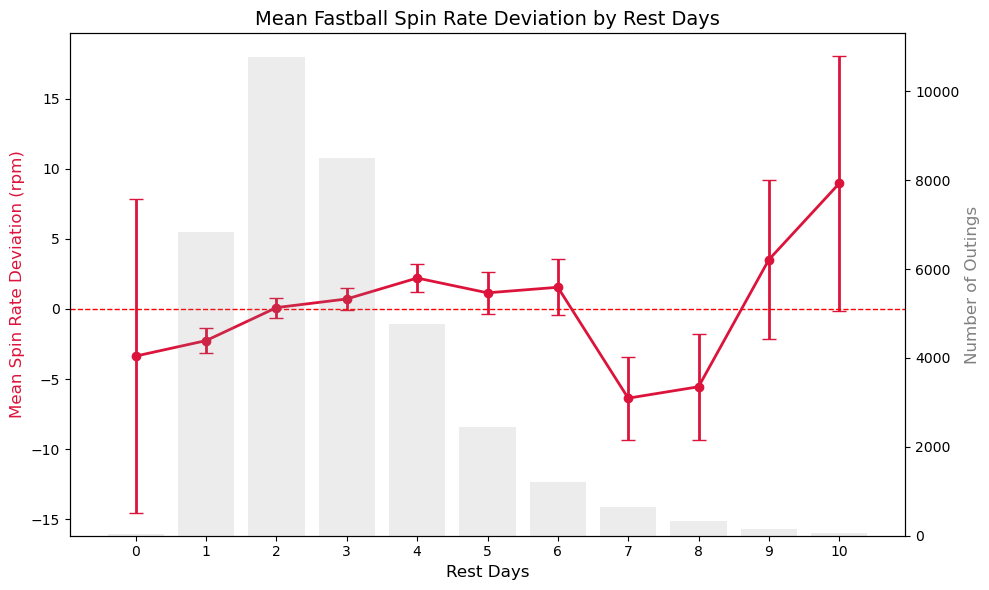

In [56]:
# 11. Mean spin rate deviation line plot with sample size overlay
fig, ax1 = plt.subplots(figsize=(10, 6))

# Line plot with error bars (left axis)
ax1.errorbar(df_spin_means['rest_days'], df_spin_means['mean_spin_dev'], yerr=df_spin_means['se'], 
             marker='o', color='crimson', linewidth=2, capsize=5)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax1.set_xlabel('Rest Days', fontsize=12)
ax1.set_ylabel('Mean Spin Rate Deviation (rpm)', fontsize=12, color='crimson')

# Bar chart for sample size (right axis)
ax2 = ax1.twinx()
ax2.bar(df_spin_means['rest_days'], df_spin_means['count'], alpha=0.15, color='gray')
ax2.set_ylabel('Number of Outings', fontsize=12, color='gray')

ax1.set_title('Mean Fastball Spin Rate Deviation by Rest Days', fontsize=14)
ax1.set_xticks(range(0, 11))
plt.tight_layout()
plt.show()

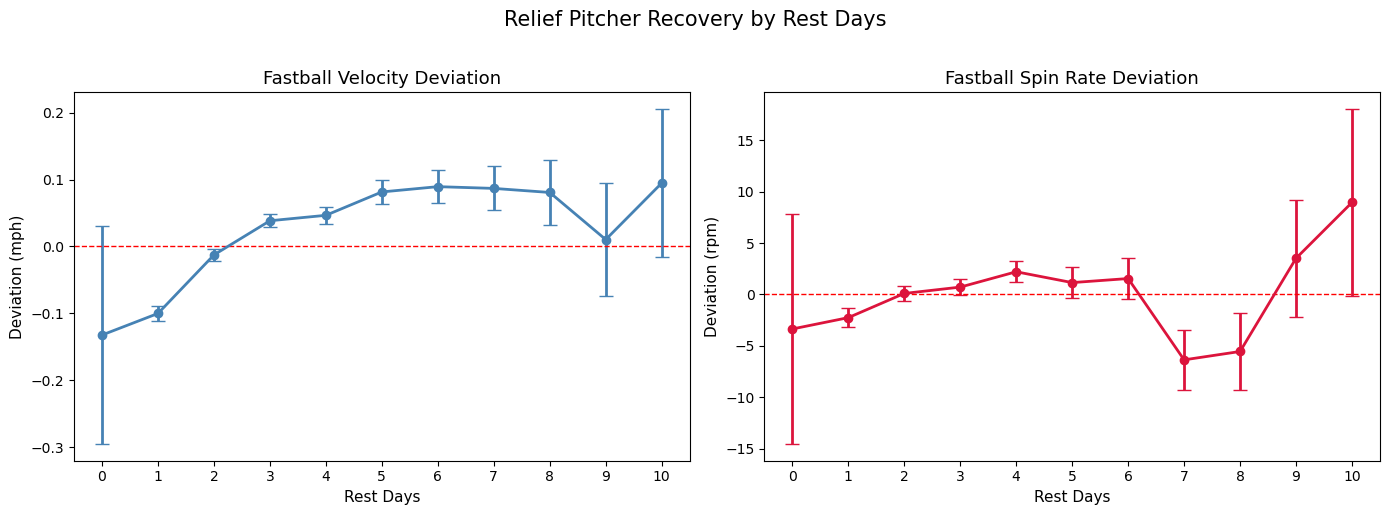

In [57]:
# 12. Side by side velocity and spin deviation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left panel - Velocity
ax1.errorbar(df_means['rest_days'], df_means['mean_velo_dev'], yerr=df_means['se'], 
             marker='o', color='steelblue', linewidth=2, capsize=5)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax1.set_title('Fastball Velocity Deviation', fontsize=13)
ax1.set_xlabel('Rest Days', fontsize=11)
ax1.set_ylabel('Deviation (mph)', fontsize=11)
ax1.set_xticks(range(0, 11))
ax1.set_xlim(-0.5, 10.5)

# Right panel - Spin Rate
ax2.errorbar(df_spin_means['rest_days'], df_spin_means['mean_spin_dev'], yerr=df_spin_means['se'], 
             marker='o', color='crimson', linewidth=2, capsize=5)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax2.set_title('Fastball Spin Rate Deviation', fontsize=13)
ax2.set_xlabel('Rest Days', fontsize=11)
ax2.set_ylabel('Deviation (rpm)', fontsize=11)
ax2.set_xticks(range(0, 11))
ax2.set_xlim(-0.5, 10.5)

fig.suptitle('Relief Pitcher Recovery by Rest Days', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

In [60]:
# 13. Regression: velocity deviation ~ rest days
from sklearn.linear_model import LinearRegression
import numpy as np

X = outing_table['rest_days'].to_numpy().reshape(-1, 1)
y = outing_table['velo_deviation'].to_numpy()

model = LinearRegression()
model.fit(X, y)
print(f"Coefficient: {model.coef_[0]:.4f} mph per rest day")
print(f"Intercept:   {model.intercept_:.4f}")
print(f"R-squared:   {model.score(X, y):.4f}")

Coefficient: 0.0321 mph per rest day
Intercept:   -0.0879
R-squared:   0.0032


In [61]:
# 14. Significance test for velocity regression
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(
    outing_table['rest_days'].to_numpy(),
    outing_table['velo_deviation'].to_numpy()
)

print(f"Slope:      {slope:.4f} mph per rest day")
print(f"P-value:    {p_value:.4f}")
print(f"Std Error:  {std_err:.4f}")
print(f"R-squared:  {r_value**2:.4f}")
print(f"\nSignificant at 0.05 level: {p_value < 0.05}")

Slope:      0.0321 mph per rest day
P-value:    0.0000
Std Error:  0.0030
R-squared:  0.0032

Significant at 0.05 level: True


### Relief pitchers show a statistically significant velocity dip of approximately 0.09 mph below their season average at 1 rest day, with both velocity and spin rate recovering toward baseline by 2-3 rest days, suggesting a threshold recovery period in the short-term performance of MLB relievers.

# Pitch Count Investigation

In [62]:
# 16. Add pitch count categories and rest day groups
(outing_with_groups := outing_table
    .with_columns([
        pl.when(pl.col('prev_pitch_count') <= 15)
          .then(pl.lit('Low (≤15)'))
          .when(pl.col('prev_pitch_count') <= 25)
          .then(pl.lit('Medium (16-25)'))
          .otherwise(pl.lit('High (>25)'))
          .alias('prev_pitch_group'),

        pl.when(pl.col('rest_days') <= 1)
          .then(pl.lit('Short (0-1)'))
          .when(pl.col('rest_days') <= 3)
          .then(pl.lit('Normal (2-3)'))
          .otherwise(pl.lit('Long (4+)'))
          .alias('rest_group'),
    ])
)

pitcher_id,game_id,date,year,pitcher_name,fb_count,mean_fb_velocity,max_fb_velocity,mean_fb_spin_rate,mean_h_movement,mean_v_movement,inning_entered,pitcher_hand,score_diff,rest_days,pitch_count,prev_pitch_count,season_avg_fb_velo,season_avg_fb_spin,velo_deviation,spin_deviation,prev_pitch_group,rest_group
i64,i64,datetime[ns],i32,str,u32,f64,f64,f64,f64,f64,i64,str,i64,i64,u32,u32,f64,f64,f64,f64,str,str
433589,634628,2021-04-06 00:00:00,2021,"""Yusmeiro Petit""",12,85.091667,87.3,2077.833333,-0.3275,1.535833,8,"""R""",-3,2,16,26,86.615973,2137.198876,-1.524306,-59.365543,"""High (>25)""","""Normal (2-3)"""
433589,634567,2021-04-07 00:00:00,2021,"""Yusmeiro Petit""",8,84.775,87.4,2039.0,-0.325,1.4825,10,"""R""",0,1,10,16,86.615973,2137.198876,-1.840973,-98.198876,"""Medium (16-25)""","""Short (0-1)"""
433589,634537,2021-04-09 00:00:00,2021,"""Yusmeiro Petit""",8,86.1375,89.2,2141.5,-0.31375,1.555,7,"""R""",0,2,8,10,86.615973,2137.198876,-0.478473,4.301124,"""Low (≤15)""","""Normal (2-3)"""
433589,632231,2021-04-12 00:00:00,2021,"""Yusmeiro Petit""",7,86.357143,87.7,2242.0,-0.18,1.548571,6,"""R""",3,3,10,8,86.615973,2137.198876,-0.25883,104.801124,"""Low (≤15)""","""Normal (2-3)"""
433589,632206,2021-04-13 00:00:00,2021,"""Yusmeiro Petit""",4,86.7,88.3,2058.5,-0.0875,1.3625,7,"""R""",0,1,6,10,86.615973,2137.198876,0.084027,-78.698876,"""Low (≤15)""","""Short (0-1)"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
702352,746985,2024-09-19 00:00:00,2024,"""Spencer Bivens""",32,94.1,97.5,2093.96875,-0.650938,0.590938,8,"""R""",-1,4,37,13,94.048879,1941.835625,0.051121,152.133125,"""Low (≤15)""","""Long (4+)"""
702352,746255,2024-09-21 00:00:00,2024,"""Spencer Bivens""",18,95.127778,97.2,2105.0,-0.842222,0.501667,7,"""R""",9,2,28,37,94.048879,1941.835625,1.078899,163.164375,"""High (>25)""","""Normal (2-3)"""
702352,747150,2024-09-23 00:00:00,2024,"""Spencer Bivens""",14,94.907143,97.1,2092.5,-0.977857,0.445714,6,"""R""",3,2,21,28,94.048879,1941.835625,0.858264,150.664375,"""High (>25)""","""Normal (2-3)"""


In [63]:
(pitch_count_summary := outing_with_groups.group_by(['prev_pitch_group', 'rest_group']).agg([
    pl.col('velo_deviation').mean().alias('mean_velo_dev'),
    pl.col('spin_deviation').mean().alias('mean_spin_dev'),
    pl.len().alias('count'),
]).sort(['prev_pitch_group', 'rest_group']))

prev_pitch_group,rest_group,mean_velo_dev,mean_spin_dev,count
str,str,f64,f64,u32
"""High (>25)""","""Long (4+)""",0.015347,-1.257961,1872
"""High (>25)""","""Normal (2-3)""",-0.050274,-0.235924,2588
"""High (>25)""","""Short (0-1)""",-0.306445,-6.265436,326
"""Low (≤15)""","""Long (4+)""",0.081187,1.833172,4050
"""Low (≤15)""","""Normal (2-3)""",0.024929,-0.075488,9240
"""Low (≤15)""","""Short (0-1)""",-0.056471,-1.94308,4183
"""Medium (16-25)""","""Long (4+)""",0.070908,1.452699,3680
"""Medium (16-25)""","""Normal (2-3)""",0.011959,1.126813,7439
"""Medium (16-25)""","""Short (0-1)""",-0.149739,-2.278411,2359


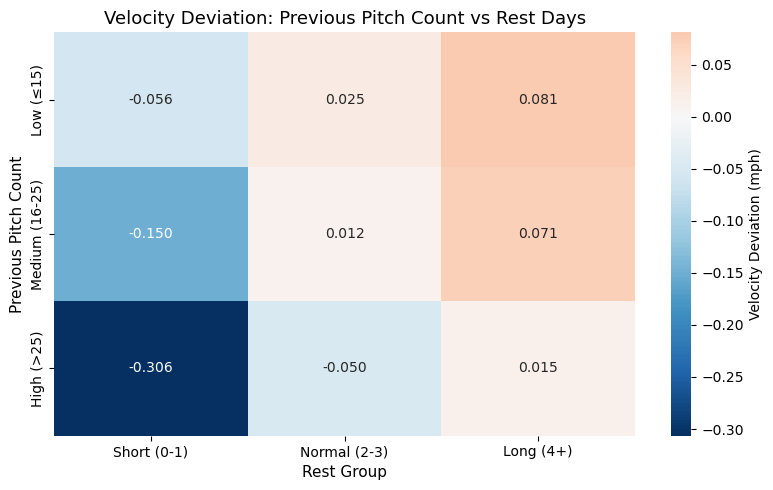

In [65]:
# 17. Heatmap of velocity deviation by pitch count group and rest group
import pandas as pd

pivot_velo = (pitch_count_summary
    .select(['prev_pitch_group', 'rest_group', 'mean_velo_dev'])
    .to_pandas()
    .pivot(index='prev_pitch_group', columns='rest_group', values='mean_velo_dev')
    [['Short (0-1)', 'Normal (2-3)', 'Long (4+)']]
)
pivot_velo = pivot_velo.loc[['Low (≤15)', 'Medium (16-25)', 'High (>25)']]

fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(pivot_velo, annot=True, fmt='.3f', cmap='RdBu_r', center=0, 
            ax=ax, cbar_kws={'label': 'Velocity Deviation (mph)'})
ax.set_title('Velocity Deviation: Previous Pitch Count vs Rest Days', fontsize=13)
ax.set_xlabel('Rest Group', fontsize=11)
ax.set_ylabel('Previous Pitch Count', fontsize=11)
plt.tight_layout()
plt.show()

In [68]:
# 18. Heatmap of spin rate deviation by pitch count group and rest group
pivot_spin = (pitch_count_summary
    .select(['prev_pitch_group', 'rest_group', 'mean_spin_dev'])
    .to_pandas()
    .pivot(index='prev_pitch_group', columns='rest_group', values='mean_spin_dev')
    [['Short (0-1)', 'Normal (2-3)', 'Long (4+)']]
)
pivot_spin = pivot_spin.loc[['Low (≤15)', 'Medium (16-25)', 'High (>25)']]

pivot_spin

rest_group,Short (0-1),Normal (2-3),Long (4+)
prev_pitch_group,,,
Low (≤15),-1.943080,-0.075488,1.833172
Medium (16-25),-2.278411,1.126813,1.452699
High (>25),-6.265436,-0.235924,-1.257961


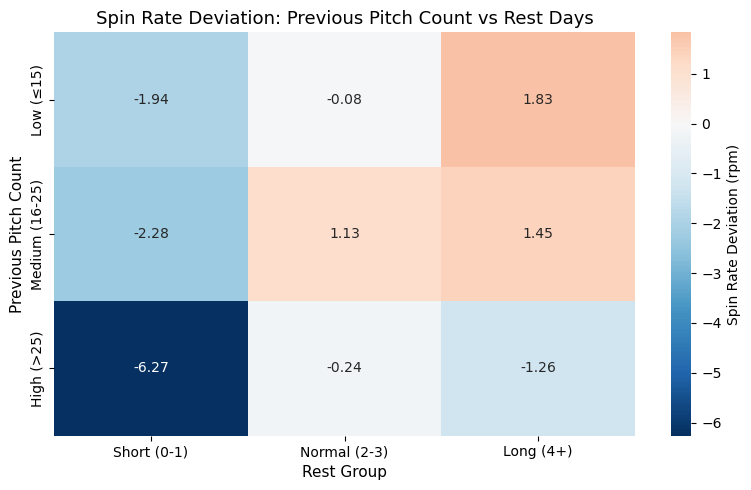

In [69]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(pivot_spin, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            ax=ax, cbar_kws={'label': 'Spin Rate Deviation (rpm)'})
ax.set_title('Spin Rate Deviation: Previous Pitch Count vs Rest Days', fontsize=13)
ax.set_xlabel('Rest Group', fontsize=11)
ax.set_ylabel('Previous Pitch Count', fontsize=11)
plt.tight_layout()
plt.show()

In [70]:
# 19. Significance test: High pitch count + Short rest vs all other outings
high_short = (outing_with_groups
    .filter(
        (pl.col('prev_pitch_group') == 'High (>25)') & 
        (pl.col('rest_group') == 'Short (0-1)')
    )
)

all_other = (outing_with_groups
    .filter(
        ~((pl.col('prev_pitch_group') == 'High (>25)') & 
          (pl.col('rest_group') == 'Short (0-1)'))
    )
)

# Velocity t-test
t_velo, p_velo = stats.ttest_ind(
    high_short['velo_deviation'].to_numpy(),
    all_other['velo_deviation'].to_numpy()
)

# Spin rate t-test
t_spin, p_spin = stats.ttest_ind(
    high_short['spin_deviation'].to_numpy(),
    all_other['spin_deviation'].to_numpy()
)

print(f"High Pitch Count + Short Rest vs All Other Outings")
print(f"\nVelocity:  t = {t_velo:.3f}, p = {p_velo:.4f}, significant: {p_velo < 0.05}")
print(f"Spin Rate: t = {t_spin:.3f}, p = {p_spin:.4f}, significant: {p_spin < 0.05}")
print(f"\nSample size (High + Short): {high_short.shape[0]}")
print(f"Sample size (All Other):    {all_other.shape[0]}")

High Pitch Count + Short Rest vs All Other Outings

Velocity:  t = -6.254, p = 0.0000, significant: True
Spin Rate: t = -1.556, p = 0.1198, significant: False

Sample size (High + Short): 326
Sample size (All Other):    35411


In [71]:
# 20. Velocity deviation within short rest only, broken out by pitch count group
short_rest_only = outing_with_groups.filter(pl.col('rest_group') == 'Short (0-1)')

low = short_rest_only.filter(pl.col('prev_pitch_group') == 'Low (≤15)')['velo_deviation'].to_numpy()
med = short_rest_only.filter(pl.col('prev_pitch_group') == 'Medium (16-25)')['velo_deviation'].to_numpy()
high = short_rest_only.filter(pl.col('prev_pitch_group') == 'High (>25)')['velo_deviation'].to_numpy()

# One-way ANOVA across the three groups
f_stat, p_anova = stats.f_oneway(low, med, high)

print(f"ANOVA: Velocity Deviation within Short Rest (0-1 days)")
print(f"\nLow (≤15):     mean = {low.mean():.4f}, n = {len(low)}")
print(f"Medium (16-25): mean = {med.mean():.4f}, n = {len(med)}")
print(f"High (>25):     mean = {high.mean():.4f}, n = {len(high)}")
print(f"\nF-statistic: {f_stat:.3f}")
print(f"P-value:     {p_anova:.4f}")
print(f"Significant: {p_anova < 0.05}")

ANOVA: Velocity Deviation within Short Rest (0-1 days)

Low (≤15):     mean = -0.0565, n = 4183
Medium (16-25): mean = -0.1497, n = 2359
High (>25):     mean = -0.3064, n = 326

F-statistic: 16.230
P-value:     0.0000
Significant: True
